### EPG CPMG fit using shaped pulses and B<sub>1</sub> parameter fitting

Fat T$_1$ = 365 ms,  T$_2$ = 80 ms

Water T$_1$ = 1400 ms T$_2$ = 35 ms


Benjamin Marty et al., Simultaneous muscle water T$_2$ and fat fraction mapping using transverse relaxometry with stimulated echo compensation, *NMR Biomed*. 2016; **29**: p431–443.

In [1]:
from __future__ import print_function

In [2]:
import guidata
_app = guidata.qapplication() # not required if a QApplication has already been created

import guidata.dataset.datatypes as dt
import guidata.dataset.dataitems as di
import numba

#import  matlab.engine

In [3]:
#from epg import cpmg_epg as cpmg_epg_c
from epg import cpmg_epg_b1 as cpmg_epg_b1_c
import time

In [4]:
import os
import sys
from string import Template
import ijroi
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib
from matplotlib import pyplot as plt

import lmfit as lm
#import cpmg_epg_hargreaves1 as epg

import seaborn as sns
import nibabel

import collections
from scipy import stats
from scipy import integrate

import uncertainties
from uncertainties import unumpy


from IPython.display import display, Markdown, Latex

from skimage.draw import (line, polygon, circle,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve)

%matplotlib  inline

c:\users\neh69\appdata\local\continuum\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# matplotlib.rc('xtick', labelsize=14) 
# matplotlib.rc('ytick', labelsize=14) 

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
class workingDirectories(dt.DataSet):
    """Set working processed directory"""
    #/media/eric/70DA58715E6C32A6/visionDMD/processed_data/newcastle_test
    procDatadir = di.DirectoryItem("Processed Data Directory", 'W:/processed_data/Newcastle_test')
    #procDatadir = di.DirectoryItem("Processed Data Directory", '/media/eric/70DA58715E6C32A6/visionDMD/processed_data/newcastle_test')
    

In [7]:
wDirs = workingDirectories()

In [8]:
wDirs.edit()

1

In [9]:
mxyz90 = np.fromfile( 'mxyz90.txt', sep=' ' )
mxyz180 = np.fromfile('mxyz180.txt', sep=' ')

mxyz90 = mxyz90.reshape(5,512)
mxyz180 = mxyz180.reshape(5,512)

offset=130
step=10
slice_xxx =mxyz90[0][offset:-offset+step:step] # mm
p90 = mxyz90[-1][offset:-offset+step:step]     # degrees
p180 = mxyz180[-1][offset:-offset+step:step]   # degrees
dx=slice_xxx[1]-slice_xxx[0]
print(len(p180),dx)

27 0.9784729999999993


In [10]:
integrate.simps(p180, x=slice_xxx)

2062.428521125722

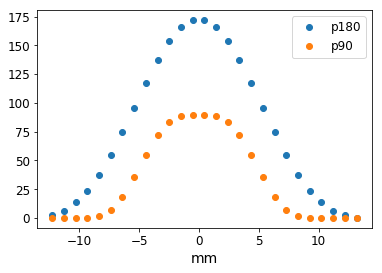

In [11]:
plt.plot(slice_xxx,p180, 'o', label='p180')
plt.plot(slice_xxx,p90, 'o', label='p90')
plt.xlabel('mm');
plt.legend();

In [12]:

def simps_eh(yyy, xxx):
    if not len(yyy)%2:
        print("length of y vector must be odd", len(yyy)%2)
        return(1)
    
    numpts = len(yyy)
    dx = (xxx[-1]-xxx[0])/(numpts-1)
    
    #( 'dx = ', dx)
    
    #
    
    yfl=yyy[0]+yyy[numpts-1]
    
    yeven = 0.0
    for i in range(1,numpts-1,2):
        #print(i, end=' ')
        yeven += 4*yyy[i]
        
   # print()
    yodd=0.0
    for i in range(2,numpts-1,2):
        #print(i, end=' ')
        yodd += 2*yyy[i]
    #print()
    
    return( (dx/3.)*(yfl+yeven+yodd))

In [13]:
simps_eh(p180, slice_xxx)

2062.428510200358

In [14]:
root_dir_structure = 'w:'

In [15]:
#[drive, subdir, mri_site, data_filename] = procDataDirList = wDirs.procDatadir.split('/')
procDataDirList = wDirs.procDatadir.split('/')

data_filename = procDataDirList[-1]
mri_site = procDataDirList[-2]
subdir = procDataDirList[-3]
procDataDirList

['W:', 'processed_data', 'Newcastle_test', '2801LW_H_01aug2017']

In [16]:
print( data_filename, mri_site, subdir)

2801LW_H_01aug2017 Newcastle_test processed_data


In [17]:
studyDataDirList = [root_dir_structure, 'study_data', mri_site, data_filename]

In [18]:
studyDataDir =  '/'.join(studyDataDirList)

In [19]:
studyDataDir

'w:/study_data/Newcastle_test/2801LW_H_01aug2017'

In [20]:
procDataDirList = [root_dir_structure, 'processed_data', mri_site, data_filename]
procDataDir = '/'.join(procDataDirList)

In [21]:
procDataDir

'w:/processed_data/Newcastle_test/2801LW_H_01aug2017'

In [22]:
procDataResultsDirList = [root_dir_structure, 'processed_data', mri_site, data_filename, 'Results']


In [23]:
procDataResultsDirList

['w:', 'processed_data', 'Newcastle_test', '2801LW_H_01aug2017', 'Results']

In [24]:
procDataResultsDir = '/'.join(procDataResultsDirList)
procDataResultsDir

if not os.path.exists(procDataResultsDir):
    os.makedirs(procDataResultsDir)

In [25]:
roiList = [s for s in os.listdir(procDataDir) if "zip" in s]
roiList

['RoiSet_UL_slice0.zip',
 'RoiSet_UL_slice1.zip',
 'RoiSet_UL_slice2.zip',
 'RoiSet_UL_slice3.zip',
 'RoiSet_UL_slice4.zip']

In [26]:
filename_hdr = procDataDir+'//'+ 'WIP_T2_multiecho_UL_CLEAR' + '.hdr'
filename_img = procDataDir+'//'+ 'WIP_T2_multiecho_UL_CLEAR' + '.img'
hdr = nibabel.load(filename_hdr)
img = nibabel.load(filename_img)
    
imageDataT2 = img.get_data()
imageDataT2.shape
    

(256, 256, 5, 17)

In [27]:
slice_number = 0
(numRowsT2, numColsT2, numSlicesT2, numEchoesT2) = imageDataT2.shape
print(filename_hdr)


w:/processed_data/Newcastle_test/2801LW_H_01aug2017//WIP_T2_multiecho_UL_CLEAR.hdr


In [28]:
# #extract header file and slice files
# headerList = [k for k in store.keys() if 'header' in k]
# summaryList = [k for k in store.keys() if 'summary' in k]
imageDataT2_rot90 = np.flipud(imageDataT2.swapaxes(1,0))


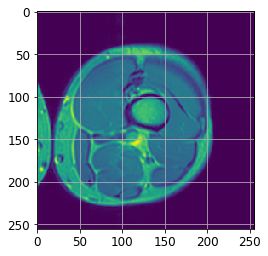

In [29]:
plt.imshow(imageDataT2_rot90[:,:,slice_number,0])
plt.grid()

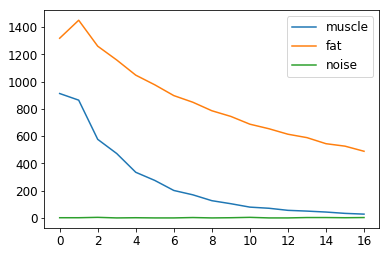

In [30]:
# header_df = store.get(headerList[0])
#plt.plot((imageDataT2_rot90[200,75,slice_number,:]))
#slice number 2
# plt.plot((imageDataT2_rot90[60,175,slice_number,:]), label='muscle')
# plt.plot((imageDataT2_rot90[110,140,slice_number,:]), label='fat')
# plt.plot((imageDataT2_rot90[225,225,slice_number,:]), label='noise')

#slice number 0
plt.plot((imageDataT2_rot90[75,150,slice_number,:]), label='muscle')
plt.plot((imageDataT2_rot90[110,140,slice_number,:]), label='fat')
plt.plot((imageDataT2_rot90[225,225,slice_number,:]), label='noise')
plt.legend();

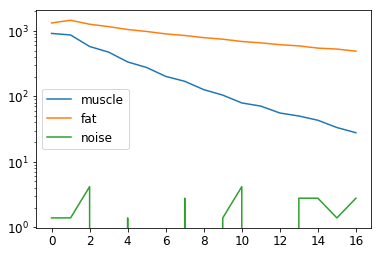

In [31]:
#slice number 2

# plt.semilogy((imageDataT2_rot90[60,175,slice_number,:]), label='muscle')
# plt.semilogy((imageDataT2_rot90[110,140,slice_number,:]), label='fat')
# plt.semilogy((imageDataT2_rot90[225,225,slice_number,:]), label='noise')
# plt.legend();


#slice number 1
plt.semilogy((imageDataT2_rot90[75,150,slice_number,:]), label='muscle')
plt.semilogy((imageDataT2_rot90[110,140,slice_number,:]), label='fat')
plt.semilogy((imageDataT2_rot90[225,225,slice_number,:]), label='noise')
plt.legend();

In [32]:
imageDataT2_rot90[75,150,slice_number,:]

array([912.7406441 , 864.11671329, 576.54089391, 472.34675646,
       334.81049502, 275.07252288, 201.44199908, 169.48913026,
       126.42222011, 104.19413745,  79.18754447,  70.85201347,
        55.57020664,  50.01318598,  43.06691015,  33.34212399,
        27.78510332])

In [33]:
imageDataT2_rot90[110,140,slice_number,:]

array([1318.40315259, 1450.38239336, 1260.05443561, 1158.63880849,
       1047.4983952 ,  976.64638174,  897.45883727,  848.83490646,
        786.31842399,  744.640769  ,  687.6813072 ,  654.33918321,
        614.0507834 ,  589.04419041,  544.58802509,  526.52770793,
        489.01781845])

In [34]:
N_in = 17.
alpha_in =121.
ESP_in = 10.24
T1_in = 365. # T1 fat
T2_in = 50.
A_in = 2000.

In [35]:
xxx = np.arange(ESP_in, (N_in+1)*ESP_in, ESP_in)
xxx

array([ 10.24,  20.48,  30.72,  40.96,  51.2 ,  61.44,  71.68,  81.92,
        92.16, 102.4 , 112.64, 122.88, 133.12, 143.36, 153.6 , 163.84,
       174.08])

In [36]:
#xxx1 = matlab.double(xxx)

In [37]:
#yyy_data = imageDataT2_rot90[60,175,slice_number,:]
#yyy_data = imageDataT2_rot90[125,30,slice_number,:]

#slice 2
yyy_fat = imageDataT2_rot90[110,140,slice_number,:]
yyy_muscle = imageDataT2_rot90[60,175,slice_number,:]

#slice 0
yyy_fat = imageDataT2_rot90[110,140,slice_number,:]
yyy_muscle = imageDataT2_rot90[75,150,slice_number,:]

In [38]:
yyy_fat_norm = yyy_fat/yyy_fat.max()
yyy_muscle_norm = yyy_muscle/yyy_muscle.max()

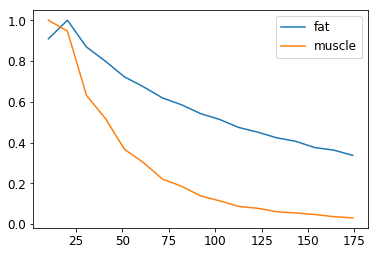

In [39]:
plt.plot(xxx,yyy_fat_norm, label='fat')
plt.plot(xxx,yyy_muscle_norm, label= 'muscle')
plt.legend()

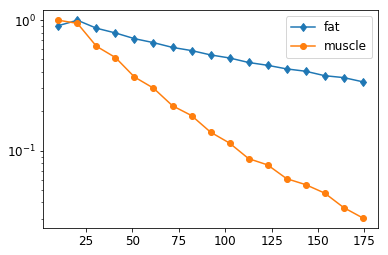

In [40]:
plt.semilogy(xxx,yyy_fat_norm, 'd-', label='fat')
plt.semilogy(xxx,yyy_muscle_norm, 'o-',label= 'muscle')
plt.legend()

In [41]:
def  epg_grad(FpFmZ, noadd=0):
    if noadd == 0:
        FpFmZ = np.concatenate((FpFmZ,np.zeros((3,1))), axis=1)
        
    FpFmZ[0,:] = np.roll(FpFmZ[0,:], 1)
    FpFmZ[1,:] = np.roll(FpFmZ[1,:],-1)
    FpFmZ[1,-1] = 0
    FpFmZ[0,0] = np.conjugate(FpFmZ[1,0])
    
    return(FpFmZ)
    
  
def epg_grelax( FpFmZ, T1, T2, T, kg = 0, D = 0, Gon = 1, noadd = 0):
    
    E1 = np.exp(-T/2.0/T1)
    E2 = np.exp(-T/2.0/T2)
    
    EE = np.diag([E2, E2, E1])
    RR = 1.0-E1
    
    FpFmZ = np.dot( EE, FpFmZ)
    
    FpFmZ[2,0] = FpFmZ[2,0]+RR
    
#     print(EE)
#     print('RR=',RR)
#     print('FpFmZ=\n',FpFmZ[:,:4].real)
    
    ##Assume Gradient is on and kg >= 0
    
    FpFmZ = epg_grad(FpFmZ, noadd)
    
    
    return(FpFmZ)


def  epg_rf( FpFmZ, alpha, phi ):
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)
    
    FpFmZ = np.dot(RR, FpFmZ)
    
    return( FpFmZ, RR)


def  rf_pulse( alpha, phi ):
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)
    
    return(RR)


def cpmg_epg_py( Nechos=17, rf_180=120.0, T1=3000.0, T2=50.0, Techo=10.0 ):
	

    P = np.zeros((3,2*Nechos),dtype=np.complex128)
    
    P[0,0] = 0.0  # Fp
    P[1,0] = 0.0  # Fm
    P[2,0] = 1.0  # Z
    
    signal = np.zeros(Nechos)
    
    rf_pulse90_rad = np.pi*rf_180/360.
    
    rf_pulse_rad = np.pi*rf_180/180.
    
    RR90  = rf_pulse(rf_pulse90_rad, np.pi/2.0)
    RR180 = rf_pulse(rf_pulse_rad,   0.0)
    
    P = np.dot(RR90,P)
    #signal[0] = P[0,0].real
    
    for echo in range(Nechos):
        P = epg_grelax( P, T1, T2, Techo)
        P = np.dot(RR180,P)
        P = epg_grelax( P, T1, T2, Techo)
        
        signal[echo] = (P[0,0].real)
        
    return(signal)

In [44]:
def fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx,  dx, p90_array, p180_array, yyy_exp=None):
    
    parvals  = params.valuesdict()
    

    
    T1fat    = parvals[ 'T1fat' ]      # fixed
    T1muscle = parvals[ 'T1muscle' ]      # fixed
    echo     = parvals[ 'echo' ]     # fixed
    T2fat    = parvals[ 'T2fat' ]     # fixed/optimized
    T2muscle = parvals['T2muscle']       # optimized
    Afat     = parvals[ 'Afat']       # optimized
    Amuscle = parvals['Amuscle']        # optimized
    B1scale = parvals['B1scale']        # optimized
    
    Nechos = len(xxx)
    Ngauss = len(p90_array)
    
    signal        = np.zeros([Ngauss,Nechos])
    fat_signal    = np.zeros(Nechos)
    muscle_signal = np.zeros(Nechos)
    
    for i,(p90,p180) in enumerate(zip(p90_array,p180_array)):

        cpmg_epg_b1_c( fat_signal,    p90, p180, T1fat,    T2fat,    echo, B1scale )
        cpmg_epg_b1_c( muscle_signal, p90, p180, T1muscle, T2muscle, echo, B1scale )
        
        signal[i] = Afat*fat_signal+Amuscle*muscle_signal
        
    int_signal = integrate.simps(signal, dx=dx,axis=0)
    if isinstance(yyy_exp, np.ndarray):   
        return( int_signal-yyy_exp)
    else:
        return(int_signal) 

### Analyze muscle

In [45]:
signal = np.zeros([21,17])
signal1 = np.zeros(17)
signal2 = np.zeros(17)

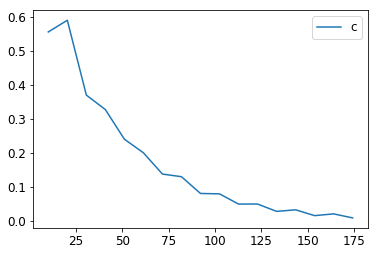

In [46]:
signal_c = np.zeros(17)
cpmg_epg_b1_c( signal_c, 80.0,120.0, 3000, 35.0, 10., 1.0)
plt.plot(xxx,signal_c, label='c');
plt.legend();

In [49]:
params = lm.Parameters()
params.add('T2fat',    value = 180.0, min=0, max=5000, vary=True)
params.add('T2muscle', value = 35,    min=0, max=100,  vary=True )
params.add('Afat',     value = 0.01,   min=0, max=10,   vary=True )
params.add('Amuscle',  value = 0.1,   min=0, max=10,   vary=True )
params.add('T1fat',    value = 365.0,                  vary=False)
params.add('T1muscle', value = 1400,                   vary=False)
params.add('echo',     value = 10.0,                   vary=False)
params.add('B1scale',  value = 1.0,    min=0, max=2.0, vary=True)

yyy_guess_integral_c  = fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx,  dx, p90, p180)

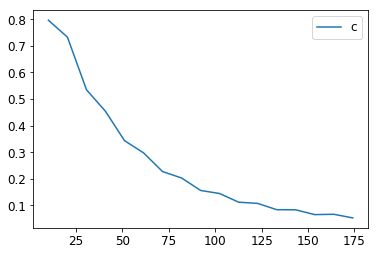

In [50]:
plt.plot(xxx, yyy_guess_integral_c, label='c');
plt.legend();

In [51]:
xxx

array([ 10.24,  20.48,  30.72,  40.96,  51.2 ,  61.44,  71.68,  81.92,
        92.16, 102.4 , 112.64, 122.88, 133.12, 143.36, 153.6 , 163.84,
       174.08])

In [52]:
# params = lm.Parameters()
# params.add('b1_scale',   value= 1.0,  min=0, max=5.0, vary=True)
# params.add('T2fat', value = 180.0, min=0, max=1000, vary=True)
# params.add('T2muscle', value = 35, min=0, max=100, vary=True)
# params.add('Afat', value = 1.0,  min=0, max=10, vary=True)
# params.add('Amuscle', value = 3,  min=0, max=10, vary=True)
# params.add('T1fat', value = 365.0, vary=False)
# params.add('T1muscle', value = 1400, vary=False)
# params.add('echo', value = 10.0, vary=False)

#xxx = np.arange(Techo, Techo*(et1+1))
yyy_data = yyy_muscle_norm
minner  = lm.Minimizer(fit_cpmg_epg_muscle_philips_hargreaves_c, params, fcn_args=( xxx, dx, p90, p180, yyy_data))

yyy_guess_integral = fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx, dx, p90, p180) 

t_start = time.time()
result = minner.minimize()
t_end = time.time()
yyy_fit_integral = fit_cpmg_epg_muscle_philips_hargreaves_c( result.params,  xxx, dx, p90, p180) 

time_c = t_end-t_start
print(time_c)

lm.report_fit(result.params)

0.0710000991821289
[[Variables]]
    T2fat:      1559.75277 +/- 3.67e+04 (2354.84%) (init= 180)
    T2muscle:   31.1914056 +/- 1.851685 (5.94%) (init= 35)
    Afat:       0.00216817 +/- 0.004997 (230.51%) (init= 0.01)
    Amuscle:    0.15794456 +/- 0.004774 (3.02%) (init= 0.1)
    T1fat:      365 (fixed)
    T1muscle:   1400 (fixed)
    echo:       10 (fixed)
    B1scale:    0.92373431 +/- 0.018740 (2.03%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(T2fat, Afat)               = -0.993 
    C(T2muscle, Afat)            = -0.937 
    C(T2fat, T2muscle)           =  0.905 
    C(Amuscle, B1scale)          = -0.650 
    C(T2fat, Amuscle)            =  0.488 
    C(T2muscle, B1scale)         =  0.472 
    C(Afat, Amuscle)             = -0.456 
    C(Afat, B1scale)             = -0.273 
    C(T2fat, B1scale)            =  0.252 
    C(T2muscle, Amuscle)         =  0.161 


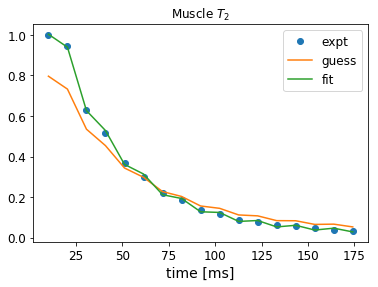

In [53]:
plt.plot(xxx,yyy_data,           'o', label='expt');
plt.plot(xxx,yyy_guess_integral, '-', label='guess');
plt.plot(xxx,yyy_fit_integral,   '-', label='fit');
plt.title('Muscle $T_2$')
plt.xlabel('time [ms]');
plt.legend();

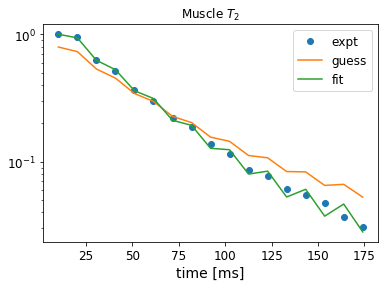

In [54]:
plt.semilogy(xxx,yyy_data,           'o', label='expt' );
plt.semilogy(xxx,yyy_guess_integral, '-', label='guess');
plt.semilogy(xxx,yyy_fit_integral,   '-', label='fit'  );
plt.title('Muscle $T_2$')
plt.xlabel('time [ms]');
plt.legend();

In [55]:
roiList

['RoiSet_UL_slice0.zip',
 'RoiSet_UL_slice1.zip',
 'RoiSet_UL_slice2.zip',
 'RoiSet_UL_slice3.zip',
 'RoiSet_UL_slice4.zip']

In [56]:
roi_filename = 'RoiSet_UL_slice' + str(slice_number) +'.zip'

In [57]:
startpos = roi_filename.rfind("slice")
slice_num = roi_filename[startpos:startpos+len("slice")+1]
print('slice_num', slice_num)

slice_num slice0


In [58]:
roi_set = ijroi.read_roi_zip(procDataDir+'//'+roi_filename)
print(roi_set)

[('VL_s0_vastus_lateralis.roi', ('polygon', array([[ 63, 132],
       [ 71, 130],
       [ 80, 141],
       [ 84, 156],
       [ 98, 168],
       [106, 172],
       [113, 177],
       [119, 182],
       [118, 187],
       [113, 192],
       [104, 190],
       [ 82, 173],
       [ 73, 161],
       [ 67, 151],
       [ 63, 141]], dtype=int16))), ('BL_s0_biceps_femoris.roi', ('polygon', array([[189, 143],
       [188, 154],
       [190, 166],
       [190, 167],
       [197, 164],
       [200, 155],
       [202, 147],
       [202, 140],
       [197, 138],
       [191, 137]], dtype=int16)))]


In [59]:
img = np.zeros((numRowsT2,numColsT2), dtype=bool)
roi_coords = {}
for roi in roi_set:
    (roiName,(roiShape,coords))=roi
    print("roiName: ", roiName,"roiShape: ",roiShape)
    
    roi_code = (roiName.split('_'))[0]
    
    print( roi_code)
    
    if roiShape == 'polygon':        
        coords=coords.transpose()
        xxxc = coords[0]
        yyyc = coords[1]
        (rr,cc) = polygon(xxxc,yyyc)
        print(roi_code,rr,cc)
        roi_coords[roi_code] = np.array([rr,cc])
        img[rr, cc] = True
        #roi_x = img_index[img.flatten()]

    elif roiShape == 'rect':        
        coords=coords.transpose()
        xxxc = coords[0]
        yyyc = coords[1]
        (rr,cc) = polygon(xxxc,yyyc)
        print(roi_code,rr,cc)
        roi_coords[roi_code] = np.array([rr,cc])
        img[rr, cc] = True
        #roi_x = img_index[img.flatten()]

    elif roiShape == 'oval':
        xc = coords[0][0]
        yc = coords[0][1]
        xr = coords[1][0]
        yr = coords[1][1]
        (rr,cc) = ellipse(yc,xc,yr,xr)
        roi_coords[roi_code] = np.array([rr,cc])
        img[rr, cc] = True
        print(roi_code,rr,cc)
    

roiName:  VL_s0_vastus_lateralis.roi roiShape:  polygon
VL
VL [ 63  63  63 ... 118 118 118] [132 133 134 ... 184 185 186]
roiName:  BL_s0_biceps_femoris.roi roiShape:  polygon
BL
BL [189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 190
 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190
 190 190 190 190 190 190 190 190 191 191 191 191 191 191 191 191 191 191
 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191
 191 191 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 193 193 193 193 193
 193 193 193 193 193 193 193 193 193 193 193 193 193 193 193 193 193 193
 193 193 193 193 193 194 194 194 194 194 194 194 194 194 194 194 194 194
 194 194 194 194 194 194 194 194 194 194 194 194 194 194 194 195 195 195
 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195
 195 195 195 195 195 195 196 196 196 196 196 196 196 196 196 196 196 196
 196 196 196 19

In [60]:
params = lm.Parameters()
params.add('T2fat',    value = 180.0, min=0, max=5000, vary=False)
params.add('T2muscle', value = 35,    min=0, max=100,  vary=True )
params.add('Afat',     value = 0.01,  min=0, max=10,   vary=True )
params.add('Amuscle',  value = 0.1,   min=0, max=10,   vary=True )
params.add('T1fat',    value = 365.0,                  vary=False)
params.add('T1muscle', value = 1400,                   vary=False)
params.add('echo',     value = 10.0,                   vary=False)
params.add('B1scale',  value = 1.0,    min=0, max=2.0, vary=True)

T2epg_results = {}

T2epg_results['slice'          ] = []
T2epg_results['roi'            ] = []
T2epg_results['pixelIndex'     ] = []
T2epg_results['T2fat_value'    ] = []
T2epg_results['T2fat_stderr'   ] = []
T2epg_results['T2muscle_value' ] = []
T2epg_results['T2muscle_stderr'] = []
T2epg_results['Afat_value'     ] = []
T2epg_results['Afat_stderr'    ] = []
T2epg_results['Amuscle_value'  ] = []
T2epg_results['Amuscle_stderr' ] = []
T2epg_results['T1muscle_value' ] = []
T2epg_results['T1fat_value'    ] = []
T2epg_results['B1scale_value'  ] = []
T2epg_results['B1scale_stderr' ] = []

t_start=time.time()

for roi_key, roi_rowcol in roi_coords.items():
    for r,c in roi_rowcol.T:
        #print(r,  end=' ')
        
        yyy_data = imageDataT2_rot90[r,c,slice_number,:]
        yyy_data = yyy_data/yyy_data.max()
        minner = lm.Minimizer(fit_cpmg_epg_muscle_philips_hargreaves_c, params, fcn_args=( xxx,dx,  p90, p180, yyy_data))
        results = minner.minimize()

        if results.success:
            T2epg_results['slice'          ].append(slice_number)
            T2epg_results['roi'            ].append(roi_key)
            T2epg_results['pixelIndex'     ].append(r*numColsT2+c)
            T2epg_results['T2fat_value'    ].append(results.params['T2fat'    ].value )
            T2epg_results['T2fat_stderr'   ].append(results.params['T2fat'    ].stderr)
            T2epg_results['T2muscle_value' ].append(results.params['T2muscle' ].value )
            T2epg_results['T2muscle_stderr'].append(results.params['T2muscle' ].stderr)
            T2epg_results['Afat_value'     ].append(results.params['Afat'     ].value )
            T2epg_results['Afat_stderr'    ].append(results.params['Afat'     ].stderr)
            T2epg_results['Amuscle_value'  ].append(results.params['Amuscle'  ].value )
            T2epg_results['Amuscle_stderr' ].append(results.params['Amuscle'  ].stderr)
            T2epg_results['B1scale_value'  ].append(results.params['B1scale'  ].value )
            T2epg_results['B1scale_stderr' ].append(results.params['B1scale'  ].stderr)
            T2epg_results['T1muscle_value' ].append(results.params['T1muscle' ].value )
            T2epg_results['T1fat_value'    ].append(results.params['T1fat'    ].value )
            

t_end = time.time()        
time_c = t_end-t_start
print (time_c)      

67.3899998664856


In [61]:
T2epg_df = pd.DataFrame(T2epg_results)

In [62]:
T2epg_df.columns

Index(['Afat_stderr', 'Afat_value', 'Amuscle_stderr', 'Amuscle_value',
       'B1scale_stderr', 'B1scale_value', 'T1fat_value', 'T1muscle_value',
       'T2fat_stderr', 'T2fat_value', 'T2muscle_stderr', 'T2muscle_value',
       'pixelIndex', 'roi', 'slice'],
      dtype='object')

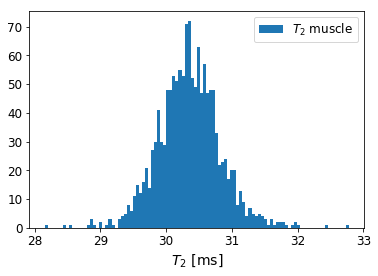

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1)

axes.hist(T2epg_df['T2muscle_value'], bins=100, label='$T_2$ muscle');
#axes.set_xlim(0,200);
#axes[1].hist(epg_vals[:,4], bins=100, label='T2f2');
axes.set_xlabel('$T_2$ [ms]');
#axes[1].set_xlabel('$T_2$ [ms]');
axes.legend();
#axes[1].legend();
#plt.savefig('png_images/muscle_T2.png');

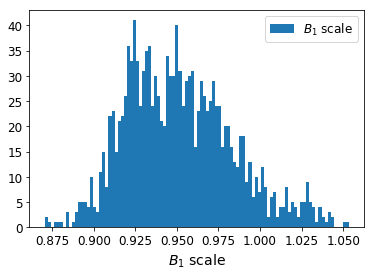

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=1)

axes.hist(T2epg_df['B1scale_value'], bins=100, label='$B_1$ scale');
#axes.set_xlim(0,200);
#axes[1].hist(epg_vals[:,4], bins=100, label='T2f2');
axes.set_xlabel('$B_1$ scale');
#axes[1].set_xlabel('$T_2$ [ms]');
axes.legend();
#axes[1].legend();
#plt.savefig('png_images/muscle_T2.png');

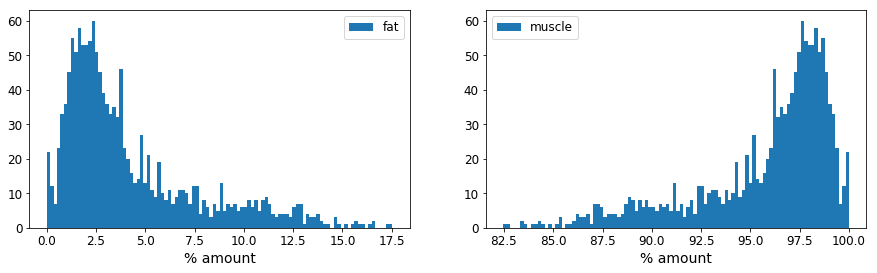

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

Am0 = T2epg_df['Amuscle_value']*100/(T2epg_df['Amuscle_value']+T2epg_df['Afat_value'])
Af0 = 100-Am0

T2epg_df['Am100']=Am0
T2epg_df['Af100']=Af0

axes[0].hist(Af0,  bins=100, label='fat');
axes[1].hist(Am0,  bins=100, label='muscle');
#axes[2].hist(epg_vals[:,3], color='green', bins=100, label='af3');
axes[0].set_xlabel('% amount');
axes[1].set_xlabel('% amount');
#axes[2].set_xlabel('amount');
axes[0].legend()
axes[1].legend()
#axes[2].legend()
#plt.savefig('png_images/muscle_amount.png');

In [66]:
t2muscle_image = np.zeros((numRowsT2*numColsT2))
B1scale_image = np.zeros((numRowsT2*numColsT2))
t2fat_image    = np.zeros((numRowsT2*numColsT2))
Amuscle_image  = np.zeros((numRowsT2*numColsT2))
Afat_image     = np.zeros((numRowsT2*numColsT2))

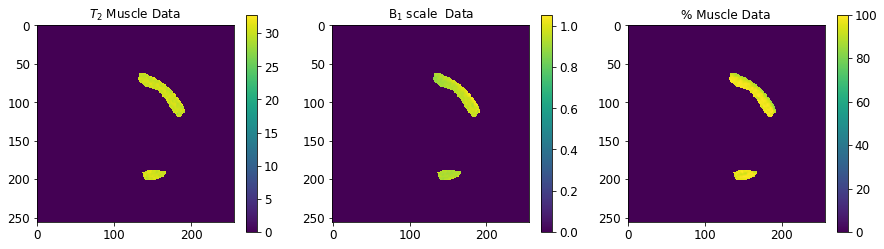

In [73]:
t2muscle_image[T2epg_df['pixelIndex']] =T2epg_df['T2muscle_value']
B1scale_image[T2epg_df['pixelIndex']] =T2epg_df['B1scale_value']
t2fat_image[T2epg_df['pixelIndex']] =T2epg_df['T2fat_value']
Amuscle_image[T2epg_df['pixelIndex']] =T2epg_df['Am100']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
hb0 =ax[0].imshow(t2muscle_image.reshape(256,256));
ax[0].set_title('$T_2$ Muscle Data');
#ax[0].colorbar();

# hb1=ax[1].imshow(t2fat_image.reshape(256,256));
# ax[1].set_title('$T_2$ Fat Data');

hb2=ax[2].imshow(Amuscle_image.reshape(256,256));
ax[2].set_title('% Muscle Data');

hb3=ax[1].imshow(B1scale_image.reshape(256,256));
ax[1].set_title('B$_1$ scale  Data');

fig.colorbar(hb0, ax=ax[0])
#fig.colorbar(hb1, ax=ax[1])
fig.colorbar(hb2, ax=ax[2])
fig.colorbar(hb3, ax=ax[1])

In [69]:
result.params['T2muscle'].value

31.191405674908207